# Saving and Loading Model Objects

In this tutorial we will repeat the models of 2b, but this time we will leave all the plotting for the end. Instead, we will store the models into a `.h5` file, delete the objects, and in the end reload them so we can perform the same analysis as was done in 2b. For details on what models are being created, we refer you back to tutorial 2b, here we will only discuss the technical components of saving and loading models.

In [1]:
import os
import uclchem

# The Prestellar Core
We will run both the initial conditions (Phase 1) and the science model (Phase 2) in one cell, storing the p_core object into the file `"../examples/test-models/models.h5"` with a name of `"prestellar_core"` so we can easily recall it later.

In [2]:
save_file = "../../examples/test-models/models.h5"

if not os.path.exists("../../examples/test-models/"):
    os.makedirs("../../examples/test-models/")

In [3]:
# set a parameter dictionary for cloud collapse model
param_dict = {
    "endAtFinalDensity": False,  # stop at finalTime
    "freefall": True,  # increase density in freefall
    "initialDens": 1e2,  # starting density
    "finalDens": 1e6,  # final density
    "initialTemp": 10.0,  # temperature of gas
    "finalTime": 6.0e6,  # final time
    "rout": 0.1,  # radius of cloud in pc
    "baseAv": 1.0,  # visual extinction at cloud edge.
}

cloud = uclchem.trialmodel.Cloud(param_dict=param_dict)
cloud.save_model(file=save_file, name="cloud", overwrite=True)

# change other bits of input to set up phase 2
param_dict["initialDens"] = 1e6
param_dict["finalTime"] = 1e6
param_dict["freefall"] = False

# freeze out is completely overwhelmed by thermal desorption
# so turning it off has no effect on abundances but speeds up integrator.
param_dict["freezeFactor"] = 0.0

param_dict["abstol_factor"] = 1e-18
param_dict["reltol"] = 1e-12

p_core = uclchem.trialmodel.PrestellarCore(temp_indx=3, max_temperature=300.0, param_dict=param_dict, previous_model=cloud)
p_core.save_model(file=save_file, name="prestellar_core", overwrite=True)

del cloud
del p_core

/home/marcuskeil/Software/anaconda3/envs/uclchem_dev/lib/python3.11/site-packages/uclchem/trialmodel.py:482: UserWarning: Model with name: `cloud` already exists in `../../examples/test-models/models.h5`, overwriting model.
  warnings.warn(f"Model with name: `{name}` already exists in `{file}`, overwriting model.")


 At T(=R1) and step size H(=R2), the                                             
 corrector convergence failed repeatedly                                         
 or with ABS(H) = HMIN.                                                          
In the above message, R1 =   0.7282697782088D+13   R2 =   0.4072842056703D+02
 ISTATE -5 - shortening step at time   230010.00000000000      years


/home/marcuskeil/Software/anaconda3/envs/uclchem_dev/lib/python3.11/site-packages/uclchem/trialmodel.py:482: UserWarning: Model with name: `prestellar_core` already exists in `../../examples/test-models/models.h5`, overwriting model.
  warnings.warn(f"Model with name: `{name}` already exists in `{file}`, overwriting model.")


We will delete the cloud and p_core object to demonstrate loading models later when we plot the results of p_core.

# Shocks
Now let's run the shock models, again, for the science explanations, we refer to tutorial 2b, instead here we simply run the models and save them.

In [13]:
param_dict = {
    "endAtFinalDensity": False,  # stop at finalTime
    "freefall": True,  # increase density in freefall
    "initialDens": 1e2,  # starting density
    "finalDens": 1e4,  # final density
    "initialTemp": 10.0,  # temperature of gas
    "finalTime": 6.0e6,  # final time
    "rout": 0.1,  # radius of cloud in pc
    "baseAv": 1.0,  # visual extinction at cloud edge.
    "abundSaveFile": "../examples/test-output/shockstart.dat",
}

shock_start = uclchem.trialmodel.Cloud(param_dict=param_dict)
shock_start.save_model(file=save_file, name="shock_start", overwrite=True)

param_dict["initialDens"] = 1e4
param_dict["finalTime"] = 1e6

cshock = uclchem.trialmodel.CShock(shock_vel=40, param_dict=param_dict, previous_model=shock_start)
cshock.save_model(file=save_file, name="cshock", overwrite=True)

param_dict["initialDens"] = 1e3
param_dict["freefall"] = False  # lets remember to turn it off this time
param_dict["reltol"] = 1e-12

jshock = uclchem.trialmodel.JShock(shock_vel=10.0, param_dict=param_dict, previous_model=shock_start, timepoints=1500)
jshock.save_model(file=save_file, name="jshock", overwrite=True)

del shock_start
del cshock
del jshock

 Cannot have freefall on during cshock
 setting freefall=0 and continuing


Having run all models and deleted the objects from the notebook, we can now show how to load models, before showcasing that the loaded objects perform exactly as regular versions of the object.

# Load the Prestellar Core

If this notebook has been run on your machine before, and the `"../examples/test-models/models.h5"` still contains the models from this tutorial, the notebook could be started from this point onward.

In [2]:
import uclchem
import matplotlib.pyplot as plt
save_file = "../../examples/test-models/models.h5"

We begin by loading the prestellar core model. We will check the conservation of elements, as well as the success flag and plot it as was done in tutorial 2b.

In [ ]:
loaded_p_core = uclchem.trialmodel.PrestellarCore.load_model(file=save_file, name="prestellar_core")
print(f'Success Flag = {loaded_p_core.success_flag}')
loaded_p_core.check_conservation()

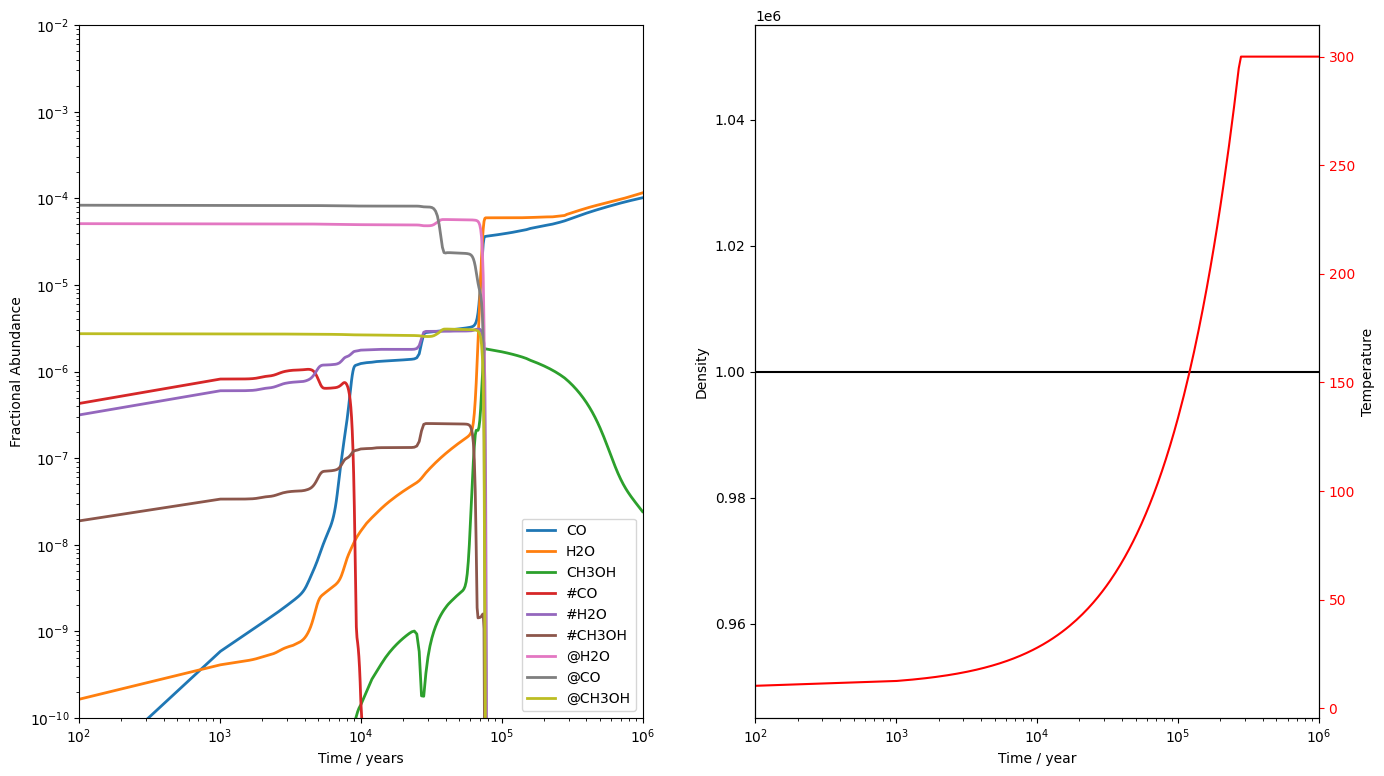

In [3]:
df_p_core = loaded_p_core.get_dataframes()
species = ["CO", "H2O", "CH3OH", "#CO", "#H2O", "#CH3OH", "@H2O", "@CO", "@CH3OH"]
fig, [ax, ax2] = plt.subplots(1, 2, figsize=(16, 9))
ax = loaded_p_core.plot_species(ax, species)
settings = ax.set(
    yscale="log",
    xlim=(1e2, 1e6),
    ylim=(1e-10, 1e-2),
    xlabel="Time / years",
    ylabel="Fractional Abundance",
    xscale="log",
)

ax2.plot(df_p_core["Time"], df_p_core["Density"], color="black")
ax2.set(xscale="log")
ax3 = ax2.twinx()
ax3.plot(df_p_core["Time"], df_p_core["gasTemp"], color="red")
ax2.set(xlabel="Time / year", ylabel="Density")
ax3.set(ylabel="Temperature", facecolor="red", xlim=(1e2, 1e6))
ax3.tick_params(axis="y", colors="red")

The way in which the loaded models are used, is equivalent to run models, and the output matches that of tutorial 2b. With that, let us look at the shock models next.

# Loading Shocks

We start again with checking the success flag, and the element conservation check for each model

In [3]:
loaded_cshock = uclchem.trialmodel.CShock.load_model(file=save_file, name="cshock")
print(f'Success Flag for cshock = {loaded_cshock.success_flag}')
print('cshock conservation check:')
loaded_cshock.check_conservation()

loaded_jshock = uclchem.trialmodel.JShock.load_model(file=save_file, name="jshock")
print(f'Success Flag for jshock = {loaded_cshock.success_flag}')
print('jshock conservation check:')
loaded_jshock.check_conservation()

Success Flag for cshock = 0
cshock conservation check:
Element conservation report
{'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}
Success Flag for jshock = 0
jshock conservation check:
Element conservation report
{'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%'}


Now we can plot the cshock, just as was done in tutorial 2b.

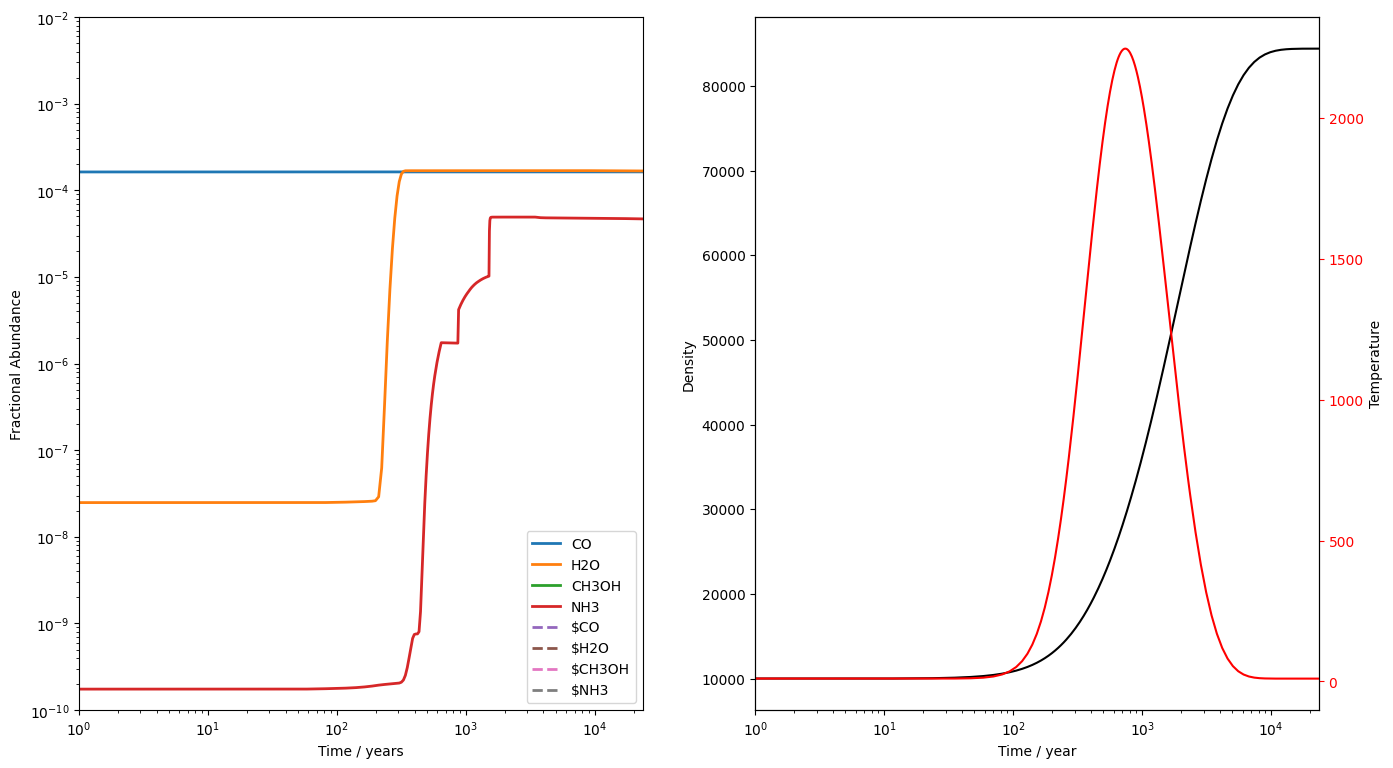

In [5]:
df_cshock = loaded_cshock.get_dataframes()
species = ["CO", "H2O", "CH3OH", "NH3", "$CO", "$H2O", "$CH3OH", "$NH3"]

fig, [ax, ax2] = plt.subplots(1, 2, figsize=(16, 9))
ax = loaded_cshock.plot_species(ax, species)
settings = ax.set(
    yscale="log",
    xlim=(1, 20 * loaded_cshock.dissipation_time),
    ylim=(1e-10, 1e-2),
    xlabel="Time / years",
    ylabel="Fractional Abundance",
    xscale="log",
)

ax2.plot(df_cshock["Time"], df_cshock["Density"], color="black")
ax2.set(xscale="log")
ax3 = ax2.twinx()
ax3.plot(df_cshock["Time"], df_cshock["gasTemp"], color="red")
ax2.set(xlabel="Time / year", ylabel="Density")
ax3.set(ylabel="Temperature", facecolor="red", xlim=(1, 20 * loaded_cshock.dissipation_time))
ax3.tick_params(axis="y", colors="red")

Followed by the plot for the jshock.

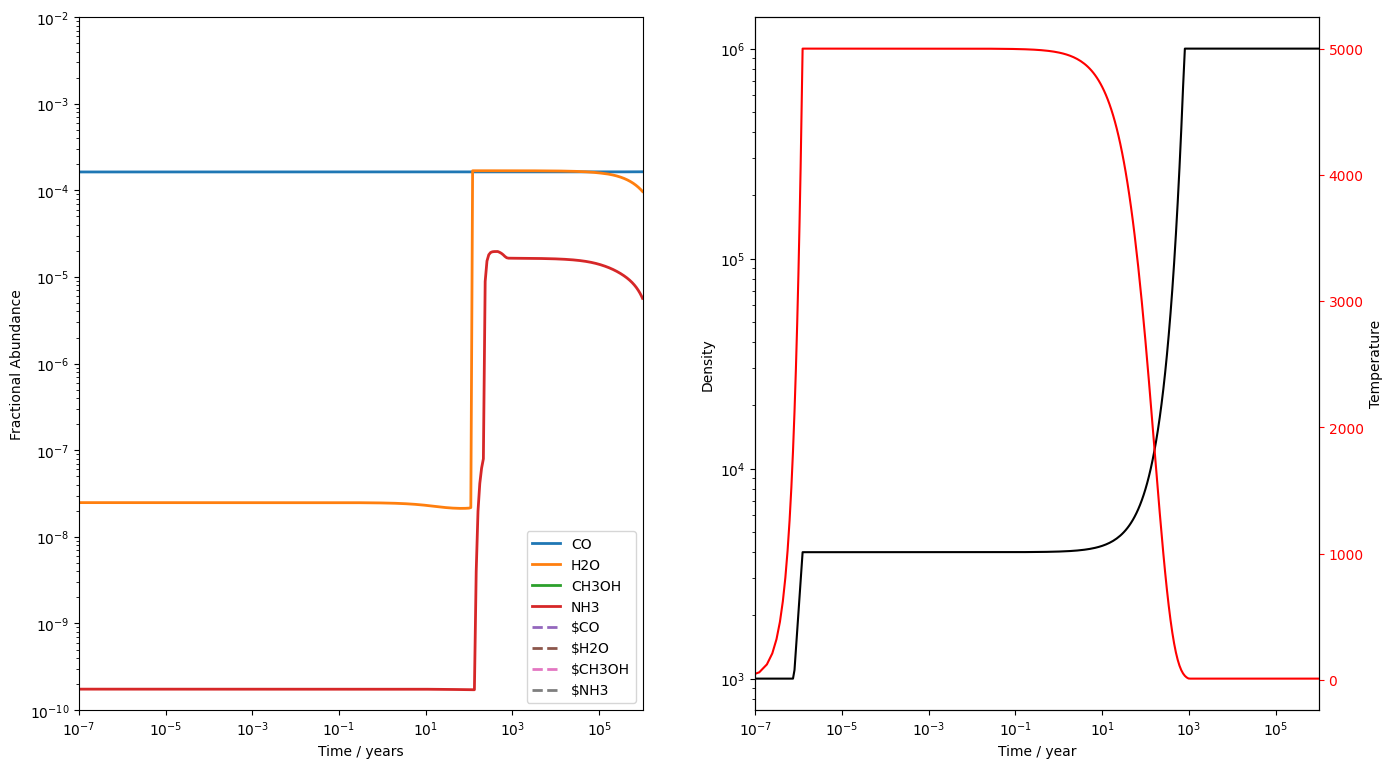

In [6]:
df_jshock = loaded_jshock.get_dataframes()
species = ["CO", "H2O", "CH3OH", "NH3", "$CO", "$H2O", "$CH3OH", "$NH3"]

fig, [ax, ax2] = plt.subplots(1, 2, figsize=(16, 9))
ax = loaded_jshock.plot_species(ax, species)
settings = ax.set(
    yscale="log",
    xlim=(1e-7, 1e6),
    ylim=(1e-10, 1e-2),
    xlabel="Time / years",
    ylabel="Fractional Abundance",
    xscale="log",
)

ax2.plot(df_jshock["Time"], df_jshock["Density"], color="black")
ax2.set(xscale="log", yscale="log")
ax3 = ax2.twinx()
ax3.plot(df_jshock["Time"], df_jshock["gasTemp"], color="red")
ax2.set(xlabel="Time / year", ylabel="Density")
ax3.set(ylabel="Temperature", facecolor="red", xlim=(1e-7, 1e6))
ax3.tick_params(axis="y", colors="red")